In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
sys.path.append('../experiments')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import neuro.features.qa_questions as qa_questions
import joblib
from tqdm import tqdm
from neuro import analyze_helper, viz
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

results_dir = analyze_helper.best_results_dir
# rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
# joblib.dump({'r': rr, 'cols_varied': cols_varied, 'mets': mets}, 'results.pkl')
data = joblib.load('results.pkl')
rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']
metric_sort = 'corrs_tune_pc_weighted_mean'

In [2]:
r = rr[rr.qa_questions_version.isin(
    ['',
     'v3_boostexamples',
     'v3_boostexamples_merged'
     ])]
r = r[r.num_stories == -1]
r = r[r.feature_selection_alpha == -1]
r = r[~r.feature_space.isin(
    ['meta-llama/Llama-2-7b-hf', 'meta-llama/Meta-Llama-3-8B'])]
cols_varied = [c for c in cols_varied if not c in ['num_stories',
                                                   'feature_selection_alpha', 'feature_selection_stability_seeds']]
r.shape

(272, 63)

In [3]:
rr

,subject,pc_components,num_stories,distill_model_path,feature_space,embedding_layer,input_chunking_type,input_chunking_size,feature_selection_alpha,feature_selection_frac,...,use_shared_feature_selection,feature_selection_alpha_index,weight_enet_mask,weight_enet_mask_num_nonzero,use_eval_brain_drive,use_added_wordrate_feature,use_random_subset_features,single_question_idx,corrs_test_mean_sem,feature_space_simplified
0,S04,100,-1,NaN,qa_embedder,-1,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000173,qa_embedder
1,S05,100,10,NaN,meta-llama/Meta-Llama-3-70B,12,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000140,llama
2,S08,100,20,NaN,meta-llama/Llama-2-70b-hf,36,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000179,llama
3,S03,100,10,NaN,qa_embedder,-1,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000217,qa_embedder
4,S05,100,-1,NaN,qa_embedder,-1,ngram,10,-1.0,0.5,...,1.0,-1.0,NaN,NaN,0.0,0.0,0.0,-1.0,0.000155,qa_embedder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,S06,100,-1,NaN,qa_embedder,-1,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000200,qa_embedder
1388,S02,100,-1,NaN,meta-llama/Llama-2-70b-hf,48,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000361,llama
1389,S03,100,-1,NaN,meta-llama/Meta-Llama-3-70B,24,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000409,llama
1390,S03,100,10,NaN,meta-llama/Llama-2-70b-hf,24,ngram,10,-1.0,0.5,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1.0,0.000270,llama


### best results breakdown

feature_space_simplified,BERT,Eng1000,LLaMA,QA-Emb,Subject
subject,,,,,
S01,0.056404,0.049082,0.040163,0.054294,S01
S02,0.112266,0.095025,0.129774,0.121913,S02
S03,0.133466,0.106534,0.141692,0.133804,S03
S04,0.000570,0.038322,0.025816,0.017847,S04
S05,0.010097,0.016812,0.006638,0.007969,S05
S06,0.035421,0.018711,0.040702,0.032639,S06
S07,0.021566,0.018535,0.024591,0.021452,S07
S08,0.008002,0.015689,0.006872,0.006851,S08
AVG,0.047224,0.044839,0.052031,0.049596,AVG


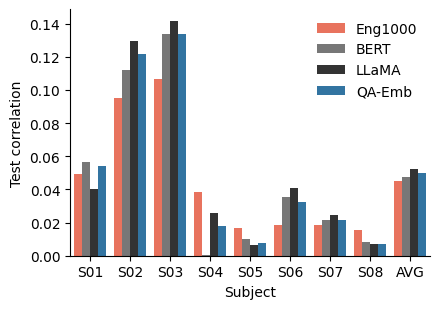

In [ ]:
d = r
# d = d[~((d.feature_space == 'qa_embedder-10') & (d.ndelays != 8))]
d = d[~((d.feature_space == 'qa_embedder') &
        (d.qa_embedding_model != 'ensemble1'))]
d = d[~((d.feature_space == 'qa_embedder') &
        (d.ndelays != 8))]
d = d[~((d.feature_space.str.contains('llama')) & (d.ndelays != 4))]
# d = d[~((d.feature_space.str.contains('bert')) & (d.ndelays != 4))]
d = d[d.pc_components == 100]

d = d.sort_values(
    by=metric_sort, ascending=False)
d = d.groupby(['subject', 'feature_space_simplified'])[mets]
d = d.first().reset_index()
# display(d)
tab = d.pivot_table(index='subject', columns='feature_space_simplified',
                    values='corrs_test_mean', aggfunc='mean')
# d.pivot_table(index='subject', columns='feature_space_simplified',
#                     values='corrs_test_mean_sem', aggfunc='mean')

# add average row
tab.loc['AVG'] = tab.mean()
# display(tab.round(3))

tab['Subject'] = tab.index.str.replace('UT', '')
# rename stuf
tab.columns = tab.columns.map(viz.feature_space_rename)
display(tab)

plot_data = tab.melt(id_vars='Subject',
                     var_name='feature_space_simplified', value_name='corrs_test_mean')
# fig, ax = plt.subplots(figsize=(4, 3))
plt.figure(figsize=(4.5, 3.2))
sns.barplot(
    plot_data, x='Subject', y='corrs_test_mean',
    hue='feature_space_simplified',
    hue_order=[
        'Eng1000', 'BERT', 'LLaMA', 'QA-Emb'],
    # , alpha=0.2)  # blues: '#52aae7', 'C0', '#004481'
    palette=['tomato', '#777', '#333', 'C0'])
# move legend outside
plt.legend(frameon=False)  # , bbox_to_anchor=(0.75, 1.2))
plt.ylabel('Test correlation')
# plt.ylim((0.05, 0.15))
plt.tight_layout()
plt.savefig('../figs/corr_best.pdf', bbox_inches='tight')
plt.show()

In [5]:
# t = tab.round(3)[['QA-Emb', 'QA-Emb (distill)',
#                   'QA-Emb (distill logits)', 'Eng1000']].astype(str)
# # bold the bottom row
# t.loc['AVG'] = t.loc['AVG'].apply(lambda x: f'\\textbf{{{x}}}')
# # bold AVG index label
# t = t.rename(index={'AVG': '\\textbf{AVG}'})
# # delete the column label name
# t.columns.name = None
# t.index.name = None

# # export to latex using booktabs
# print(t.to_latex(escape=False, column_format='lrrrr', float_format='%.3f'))

### qa version breakdowns

In [6]:
d = r[(r.feature_space == 'qa_embedder')]
d = d[(d.pc_components == 100)]
# d = d[d.ndelays == 8]
# d = d[~d.qa_embedding_model.str.contains('mixt')]
d['qa_questions_version'] = d['qa_questions_version'].apply(
    viz.version_rename)
cols = ['subject', 'ndelays', 'qa_questions_version', 'qa_embedding_model']
d = d.groupby(cols)[mets].mean()
d = (
    d.pivot_table(index=[c for c in cols if not c == 'qa_embedding_model'],
                  columns='qa_embedding_model', values='corrs_test_mean', aggfunc='mean')
)
# add average row to multiindex
# for qa_questions_version in sorted(d.index.get_level_values('qa_questions_version').unique()):
# dn = d.loc[(slice(None), qa_questions_version), :]
# d.loc[('AVG', qa_questions_version), :] = dn.mean()
display(
    d
    .style.background_gradient(cmap='magma')  # , axis=1)  # , axis=0)
    .format(precision=3)
)

# d = d.drop(columns='llama3-8B-refined')
# d.columns.name = None
# d.index.names = ['Subject', 'Questions']
# d.columns = d.columns.map(viz.feature_space_rename)
# d = d.loc[(slice(None), ['Prompts 1-3 (376 questions)',
#            'Prompts 1-5 (518 questions)', 'Prompts 1-6 (674 questions)']), :]
# print(d.to_latex(escape=False, float_format='%.3f').replace(
#     '\cline{1-5}', '\midrule'))

In [7]:
d = r[(~r.feature_space.str.contains('qa_embedder'))]
d = d[d.pc_components == 100]
d = d[(~d.feature_space.str.contains('roberta'))]
# d = r[(r.pc_components == 100)]
# d = d[d.ndelays == 8]
cols = [c for c in cols_varied if not c in [
    'qa_embedding_model', 'qa_questions_version']]
if not 'subject' in cols:
    cols_varied.append('subject')
cols_top = ['feature_space', 'embedding_layer']
d = d.groupby(cols_varied)[mets].mean()
d = (
    d.pivot_table(index=[c for c in cols if not c in cols_top],
                  columns=cols_top, values='corrs_test_mean', aggfunc='mean')
    .rename(columns=viz.feature_space_rename)
    # sort columns alphabetically
    .sort_index(axis=1)
)
# add average row to multiindex
# for ndelays in sorted(d.index.get_level_values('ndelays').unique()):
#     dn = d.loc[(slice(None), ndelays), :]
#     d.loc[('AVG', ndelays), :] = dn.mean()


# d.columns.name = None
# d.index.names = ['Subject', 'Delays']
display(d
        .style.background_gradient(cmap='viridis', axis=1)  # , axis=0)
        .format(precision=3)
        )
# print(d.T.to_latex(escape=False, float_format='%.3f'))

In [8]:
# # look at distill_model_path
# d = r[(r.feature_space == 'qa_embedder-10') * (r.pc_components == 100)]
# d = d.groupby(cols_varied)[mets].mean()
# d.pivot_table(index=[c for c in cols_varied if not c == 'distill_model_path'],
#               columns='distill_model_path', values='corrs_test_mean', aggfunc='mean')

### look at all results

In [9]:
d = r
# d = d[d.feature_space == 'eng1000']
# d = d[d.subject == 'UTS01']
# d = d[~(d.feature_space == 'qa_embedder-10') | (d.ndelays == 8)]
# d = d[d.feature_space == 'llama']
cols_varied = [c for c in cols_varied if not c in [
    'distill_model_path', 'feature_selection_alpha_index']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets].mean()
else:
    d = d[mets]

(
    d
    .sort_values(by='corrs_test_mean', ascending=False)
    # .sort_values(by=metric_sort, ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)

# Compare performance of a few different models

In [10]:
# qa = r[(r.feature_space == 'qa_embedder-5')
# ].sort_values(by='corrs_tune_pc_mean', ascending=False).iloc[0]
qa = r.iloc[0]
eng1000 = r[(r.feature_space == 'eng1000')].sort_values(
    by='corrs_tune_pc_mean', ascending=False).iloc[0]

ValueError: x and y must have same first dimension, but have shapes (109469,) and (95556,)

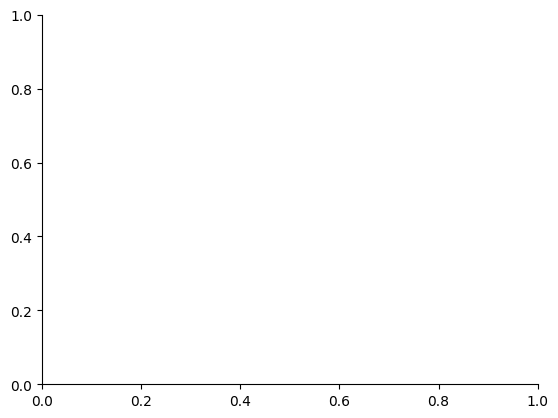

In [11]:
plt.plot(qa['corrs_test'], eng1000['corrs_test'], '.', ms=1)
plt.xlabel(f'QA Embedder (mean: {qa["corrs_test"].mean():0.3f})')
plt.ylabel(f'Eng1000 (mean: {eng1000["corrs_test"].mean():0.3f})')
plt.title('Test Correlations')
m_max = max(qa['corrs_test'].max(), eng1000['corrs_test'].max())
m_min = min(qa['corrs_test'].min(), eng1000['corrs_test'].min())
plt.plot([m_min, m_max], [m_min, m_max], 'k--')
plt.show()

### Check parameters for rerunning expts (alphas, delays)

In [ ]:
args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
args = r.sort_values(by='corrs_test_mean').iloc[-1]
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space, args.pc_components, args.ndelays)

In [ ]:
# print which alphas are being used
pd.Series(model_params_to_save['alphas_best']).value_counts()

### Hybrid models (use pc_components == 1 when it predicts better)

In [ ]:
args = r[(r.pc_components == -1) * (r.feature_space == 'qa_embedder-5')
         ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
args2 = r[(r.pc_components > 0) * (r.feature_space == 'qa_embedder-5')
          ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
# args = r[]

# args2 = r[(r.feature_space == 'eng1000')].iloc[0]
# args = r[(r.pc_components == -1) * (r.feature_space == 8)].iloc[0]
# args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
# model_params_to_save = joblib.load(
# join(args.save_dir_unique, 'model_params.pkl'))

In [ ]:
percentile_thresholds = np.arange(0, 100, 1)
corrs_tune_individual = args['corrs_tune']
corrs_test_individual = args['corrs_test']
corrs_test_pca = args2['corrs_test']
res = []
for percentile_threshold in percentile_thresholds:
    args_top_thresh = np.where(corrs_tune_individual > np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_non_top_thresh = np.where(corrs_tune_individual <= np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_total = np.concatenate([args_top_thresh, args_non_top_thresh])
    mean_corr_weighted = (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
                          corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    # print('mean corr weighted',
    #       (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
    #        corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    #       )
    res.append(mean_corr_weighted)
plt.plot(percentile_thresholds, res)
plt.axhline(corrs_test_individual.mean(), color='k', linestyle='--')
plt.axhline(corrs_test_pca.mean(), color='r', linestyle='--')
plt.show()